# Basic demo

Here we give a basic demo of how to work with OpenSCM-Calibration. However, we run it for long enough that the results are meaningful and interesting.

## Imports

In [1]:
from functools import partial
from typing import Callable, Dict, Tuple

import emcee
import matplotlib.pyplot as plt
import more_itertools
import numpy as np
import pandas as pd
import pint
import scipy.integrate
import scmdata.run
from emcwrap import DIMEMove
from multiprocess import Pool, Manager
from openscm_units import unit_registry as UREG
from tqdm.notebook import tqdm

import openscm_calibration
from openscm_calibration import emcee_plotting
from openscm_calibration.cost import OptCostCalculatorSSE
from openscm_calibration.emcee_utils import (
    get_acceptance_fractions,
    get_autocorrelation_info,
)
from openscm_calibration.minimize import to_minimize_full
from openscm_calibration.model_runner import OptModelRunner
from openscm_calibration.scipy_plotting import (
    CallbackProxy,
    OptPlotter,
    get_ymax_default,
)
from openscm_calibration.scmdata_utils import scmrun_as_dict
from openscm_calibration.store import OptResStore

/Users/znicholls/Documents/AGCEC/MCastle/openscm-calibration_examples/.venv/lib/python3.11/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
print(f"{openscm_calibration.__version__=}")

openscm_calibration.__version__='0.5.0'


## Background

In this notebook we're going to run a simple model to solve the following equation for the motion of a mass on a damped spring

\begin{align*}
v &= \frac{dx}{dt} \\
m \frac{dv}{dt} &= -k (x - x_0) - \beta v
\end{align*}

where $v$ is the velocity of the mass, $x$ is the position of the mass, $t$ is time, $m$ is the mass of the mass, $k$ is the spring constant, $x_0$ is the equilibrium position and $\beta$ is a damping constant.

We are going to solve this system using [scipy's solve initial value problem](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

We want to support units, so we implement this using [pint](https://pint.readthedocs.io/).

## Experiments

We're going to calibrate the model's response in two experiments:

- starting out of equilibrium
- starting at the equilibrium position but already moving

In [3]:
LENGTH_UNITS = "m"
MASS_UNITS = "Pt"
TIME_UNITS = "yr"
time_axis = UREG.Quantity(np.arange(1850, 2000, 1), TIME_UNITS)
mass = UREG.Quantity(100, MASS_UNITS)

In [4]:
def do_experiments_full(
    k: pint.Quantity, x_zero: pint.Quantity, beta: pint.Quantity, m: pint.Quantity
) -> scmdata.run.BaseScmRun:
    """
    Run model experiments

    Parameters
    ----------
    k
        Spring constant [kg / s^2]

    x_zero
        Equilibrium position [m]

    beta
        Damping constant [kg / s]
        
    m
        Mass [kg]

    Returns
    -------
        Results
    """
    # Avoiding pint conversions in the function actually
    # being solved makes things much faster, but also
    # harder to keep track of. We recommend starting with
    # pint everywhere first, then optimising second (either
    # via using numpy quantities throughout, optional numpy
    # quantities using e.g. pint.wrap or using Fortran or
    # C wrappers).
    k_m = k.to(f"{MASS_UNITS} / {TIME_UNITS}^2").m
    x_zero_m = x_zero.to(LENGTH_UNITS).m
    beta_m = beta.to(f"{MASS_UNITS} / {TIME_UNITS}").m
    m_m = m.to(MASS_UNITS).m

    def to_solve(t: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Right-hand side of our equation i.e. dN/dt

        Parameters
        ----------
        t
            time

        y
            Current stat of the system

        Returns
        -------
            dN/dt
        """
        x = y[0]
        v = y[1]

        dv_dt = (-k_m * (x - x_zero_m) - beta_m * v) / m_m
        dx_dt = v

        out = np.array([dx_dt, dv_dt])

        return out

    res = {}
    time_axis_m = time_axis.to(TIME_UNITS).m
    for name, to_solve_l, x_start, v_start in (
        (
            "non-eqm-start",
            to_solve,
            UREG.Quantity(1.2, "m"),
            UREG.Quantity(0, "m / s"),
        ),
        ("eqm-start", to_solve, x_zero, UREG.Quantity(0.3, "m / yr")),
    ):
        res[name] = scipy.integrate.solve_ivp(
            to_solve_l,
            t_span=[time_axis_m[0], time_axis_m[-1]],
            y0=[
                x_start.to(LENGTH_UNITS).m,
                v_start.to(f"{LENGTH_UNITS} / {TIME_UNITS}").m,
            ],
            t_eval=time_axis_m,
        )
        if not res[name].success:
            raise ValueError("Model failed to solve")

    out = scmdata.run.BaseScmRun(
        pd.DataFrame(
            np.vstack([res["non-eqm-start"].y[0, :], res["eqm-start"].y[0, :]]),
            index=pd.MultiIndex.from_arrays(
                (
                    ["position", "position"],
                    [LENGTH_UNITS, LENGTH_UNITS],
                    ["non-eqm-start", "eqm-start"],
                ),
                names=["variable", "unit", "scenario"],
            ),
            columns=time_axis.to(TIME_UNITS).m,
        )
    )
    out["model"] = "example"

    return out


do_experiments = partial(do_experiments_full, m=mass)

### Target

For this example, we're going to use a known configuration as our target so we can make sure that we optimise to the right spot. In practice, we won't know the correct answer before we start so this setup will generally look a bit different (typically we would be loading data from some other source to which we want to calibrate).

/Users/znicholls/Documents/AGCEC/MCastle/openscm-calibration_examples/.venv/lib/python3.11/site-packages/scmdata/plotting.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


<BaseScmRun (timeseries: 2, timepoints: 150)>
Time:
	Start: 1850-01-01T00:00:00
	End: 1999-01-01T00:00:00
Meta:
	    model       scenario unit  variable
	0  target  non-eqm-start    m  position
	1  target      eqm-start    m  position

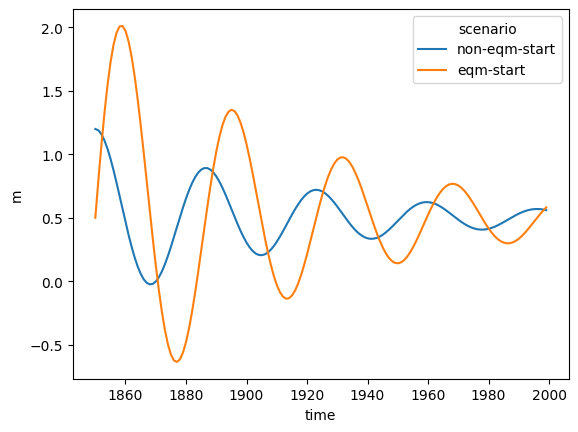

In [5]:
truth = {
    "k": UREG.Quantity(3000, "kg / s^2"),
    "x_zero": UREG.Quantity(0.5, "m"),
    "beta": UREG.Quantity(1e11, "kg / s"),
}

target = do_experiments(**truth)
target["model"] = "target"
target.lineplot(time_axis="year-month")
target

### Cost calculation

The next thing is to decide how we're going to calculate the cost function. There are many options here, in this case we're going to use the sum of squared errors.

In [6]:
normalisation = pd.Series(
    [0.1],
    index=pd.MultiIndex.from_arrays(
        (
            [
                "position",
            ],
            ["m"],
        ),
        names=["variable", "unit"],
    ),
)

cost_calculator = OptCostCalculatorSSE.from_series_normalisation(
    target=target, normalisation_series=normalisation, model_col="model"
)
assert cost_calculator.calculate_cost(target) == 0
assert cost_calculator.calculate_cost(target * 1.1) > 0
cost_calculator

OptCostCalculatorSSE(target=<BaseScmRun (timeseries: 2, timepoints: 150)>
Time:
	Start: 1850-01-01T00:00:00
	End: 1999-01-01T00:00:00
Meta:
	    model       scenario unit  variable
	0  target  non-eqm-start    m  position
	1  target      eqm-start    m  position, model_col='model', normalisation=<BaseScmRun (timeseries: 2, timepoints: 150)>
Time:
	Start: 1850-01-01T00:00:00
	End: 1999-01-01T00:00:00
Meta:
	    model       scenario unit  variable
	0  target  non-eqm-start    m  position
	1  target      eqm-start    m  position)

### Model runner

Scipy does everything using numpy arrays. Here we use a wrapper that converts them to pint quantities before running.

Firstly, we define the parameters we're going to optimise. This will be used to ensure a consistent order throughout.

In [7]:
parameters = [
    ("k", f"{MASS_UNITS} / {TIME_UNITS} ^ 2"),
    ("x_zero", LENGTH_UNITS),
    ("beta", f"{MASS_UNITS} / {TIME_UNITS}"),
]
parameters

[('k', 'Pt / yr ^ 2'), ('x_zero', 'm'), ('beta', 'Pt / yr')]

Next we define a function which, given pint quantities, returns the inputs needed for our `do_experiments` function. In this case this is not a very interesting function, but in other use cases the flexibility is helpful.

In [8]:
def do_model_runs_input_generator(
    k: pint.Quantity, x_zero: pint.Quantity, beta: pint.Quantity
) -> Dict[str, pint.Quantity]:
    """
    Create the inputs for :func:`do_experiments`

    Parameters
    ----------
    k
        k

    x_zero
        x_zero

    beta
        beta

    Returns
    -------
        Inputs for :func:`do_experiments`
    """
    return {"k": k, "x_zero": x_zero, "beta": beta}

In [9]:
model_runner = OptModelRunner.from_parameters(
    params=parameters,
    do_model_runs_input_generator=do_model_runs_input_generator,
    do_model_runs=do_experiments,
)
model_runner

OptModelRunner(convert_x_to_names_with_units=functools.partial(<function x_and_parameters_to_named_with_units at 0x1250b3600>, params=[('k', 'Pt / yr ^ 2'), ('x_zero', 'm'), ('beta', 'Pt / yr')]), do_model_runs_input_generator=<function do_model_runs_input_generator at 0x12523d4e0>, do_model_runs=functools.partial(<function do_experiments_full at 0x1250da7a0>, m=<Quantity(100, 'petametric_ton')>))

Now we can run from a plain numpy array (like scipy will use) and get a result that will be understood by our cost calculator.

In [10]:
cost_calculator.calculate_cost(model_runner.run_model([3, 0.5, 3]))

7.48082272283305

Now we're ready to optimise.

## Global optimisation

Scipy has many [global optimisation options](https://docs.scipy.org/doc/scipy/reference/optimize.html#global-optimization). Here we show how to do this with differential evolution, but using others would be equally simple.

We have to define where to start the optimisation.

In [11]:
start = np.array([4, 0.6, 2])
start

array([4. , 0.6, 2. ])

For this optimisation, we must also define bounds for each parameter.

In [12]:
bounds_dict = {
    "k": [
        UREG.Quantity(300, "kg / s^2"),
        UREG.Quantity(1e4, "kg / s^2"),
    ],
    "x_zero": [
        UREG.Quantity(-2, "m"),
        UREG.Quantity(2, "m"),
    ],
    "beta": [
        UREG.Quantity(1e10, "kg / s"),
        UREG.Quantity(1e12, "kg / s"),
    ],
}
display(bounds_dict)

bounds = [[v.to(unit).m for v in bounds_dict[k]] for k, unit in parameters]
bounds

{'k': [300 <Unit('kilogram / second ** 2')>,
  10000.0 <Unit('kilogram / second ** 2')>],
 'x_zero': [-2 <Unit('meter')>, 2 <Unit('meter')>],
 'beta': [10000000000.0 <Unit('kilogram / second')>,
  1000000000000.0 <Unit('kilogram / second')>]}

[[0.298764635328, 9.9588211776], [-2, 2], [0.315576, 31.557600000000004]]

Now we're ready to run our optimisation.

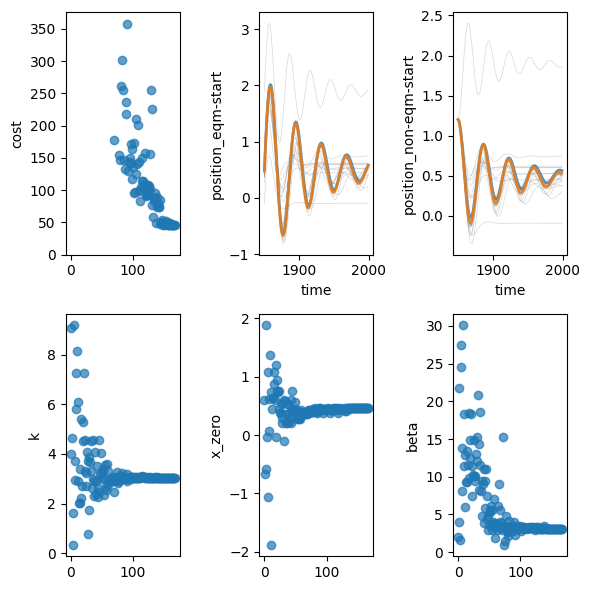

  0%|          | 0/612 [00:00<?, ?it/s]

     fun: 45.72328578101859
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 13
 success: True
       x: array([3.02972562, 0.46913996, 3.10801773])

In [13]:
# Number of parallel processes to use
processes = 4

# Random seed (use if you want reproducibility)
seed = 374839

## Optimisation parameters
# Tolerance to set for convergance
atol = 1
tol = 0.02
# Maximum number of iterations to use
maxiter = 50
# Lower mutation means faster convergence but smaller
# search radius
mutation = (0.1, 0.8)
# Higher recombination means faster convergence but
# might miss global minimum
recombination = 0.8
# Size of population to use (higher number means more searching
# but slower convergence)
popsize = 4
# There are also the strategy and init options
# which might be needed for some problems

# Maximum number of runs to store
max_n_runs = (maxiter + 1) * popsize * len(parameters)


# Visualisation options
update_every = 4
thin_ts_to_plot = 5


# Create axes to plot on (could also be created as part of a factory
# or class method)
convert_scmrun_to_plot_dict = partial(scmrun_as_dict, groups=["variable", "scenario"])

cost_name = "cost"
timeseries_axes = list(convert_scmrun_to_plot_dict(target).keys())

parameters_names = [v[0] for v in parameters]
parameters_mosiac = list(more_itertools.repeat_each(parameters_names, 1))
timeseries_axes_mosiac = list(more_itertools.repeat_each(timeseries_axes, 1))

fig, axd = plt.subplot_mosaic(
    mosaic=[
        [cost_name] + timeseries_axes_mosiac,
        parameters_mosiac,
    ],
    figsize=(6, 6),
)
holder = display(fig, display_id=True)


with Manager() as manager:
    store = OptResStore.from_n_runs_manager(
        max_n_runs,
        manager,
        params=parameters_names,
    )

    # Create objects and functions to use
    to_minimize = partial(
        to_minimize_full,
        store=store,
        cost_calculator=cost_calculator,
        model_runner=model_runner,
        known_error=ValueError,
    )

    with manager.Pool(processes=processes) as pool:
        with tqdm(total=max_n_runs) as pbar:
            opt_plotter = OptPlotter(
                holder=holder,
                fig=fig,
                axes=axd,
                cost_key=cost_name,
                parameters=parameters_names,
                timeseries_axes=timeseries_axes,
                convert_scmrun_to_plot_dict=convert_scmrun_to_plot_dict,
                target=target,
                store=store,
                thin_ts_to_plot=thin_ts_to_plot,
            )

            proxy = CallbackProxy(
                real_callback=opt_plotter,
                store=store,
                update_every=update_every,
                progress_bar=pbar,
                last_callback_val=0,
            )

            optimize_res = scipy.optimize.differential_evolution(
                to_minimize,
                bounds,
                maxiter=maxiter,
                x0=start,
                tol=tol,
                atol=atol,
                seed=seed,
                # Polish as a second step if you want
                polish=False,
                workers=pool.map,
                updating="deferred",  # as we run in parallel, this has to be used
                mutation=mutation,
                recombination=recombination,
                popsize=popsize,
                callback=proxy.callback_differential_evolution,
            )

plt.close()
optimize_res

## Local optimisation

Scipy also has [local optimisation](https://docs.scipy.org/doc/scipy/reference/optimize.html#local-multivariate-optimization) (e.g. Nelder-Mead) options. Here we show how to do this.

Again, we have to define where to start the optimisation (this has a greater effect on local optimisation).

In [14]:
# The typical way to do local optimisation is to polish
# the results of a more global optimisation like differential
# evolution above. We do that here, but you could also use a 
# random start too
start_local = optimize_res.x
start_local

array([3.02972562, 0.46913996, 3.10801773])

  0%|          | 0/603 [00:00<?, ?it/s]

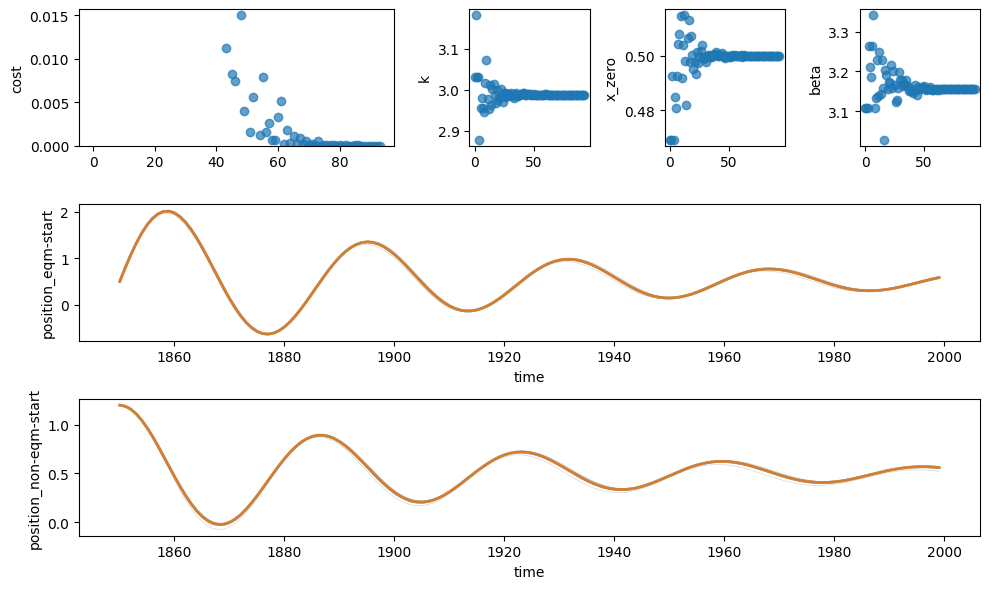

 final_simplex: (array([[2.98764573, 0.50000399, 3.15576414],
       [2.98764759, 0.50000064, 3.15570193],
       [2.98763154, 0.49999956, 3.15575025],
       [2.98764986, 0.49999085, 3.15582127]]), array([5.13150957e-07, 8.05891938e-07, 1.83189480e-06, 3.34335609e-06]))
           fun: 5.131509568272215e-07
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 49
        status: 0
       success: True
             x: array([2.98764573, 0.50000399, 3.15576414])

In [15]:
# Optimisation parameters
tol = 1e-4
# Maximum number of iterations to use
maxiter = 300

# I think this is how this works
max_n_runs = len(parameters) + 2 * maxiter

# Lots of options here
method = "Nelder-mead"

# Visualisation options
update_every = 10
thin_ts_to_plot = 5
parameters_names = [v[0] for v in parameters]

# Create other objects
store = OptResStore.from_n_runs(max_n_runs, params=parameters_names)
to_minimize = partial(
    to_minimize_full,
    store=store,
    cost_calculator=cost_calculator,
    model_runner=model_runner,
)


with tqdm(total=max_n_runs) as pbar:
    # Here we use a class method which auto-generates the figure
    # for us. This is just a convenience thing, it does the same
    # thing as the previous example under the hood.
    opt_plotter = OptPlotter.from_autogenerated_figure(
        cost_key=cost_name,
        params=parameters_names,
        convert_scmrun_to_plot_dict=convert_scmrun_to_plot_dict,
        target=target,
        store=store,
        thin_ts_to_plot=thin_ts_to_plot,
        kwargs_create_mosaic=dict(
            n_parameters_per_row=3,
            n_timeseries_per_row=1,
            cost_col_relwidth=2,
        ),
        kwargs_get_fig_axes_holder=dict(figsize=(10, 6)),
        plot_cost_kwargs={
            "alpha": 0.7,
            "get_ymax": partial(
                get_ymax_default, min_scale_factor=1e6, min_v_median_scale_factor=0
            ),
        },
    )

    proxy = CallbackProxy(
        real_callback=opt_plotter,
        store=store,
        update_every=update_every,
        progress_bar=pbar,
        last_callback_val=0,
    )

    optimize_res_local = scipy.optimize.minimize(
        to_minimize,
        x0=start_local,
        tol=tol,
        method=method,
        options={"maxiter": maxiter},
        callback=proxy.callback_minimize,
    )

plt.close()
optimize_res_local

## MCMC

To run MCMC, we use the [emcee](https://emcee.readthedocs.io/) package. This has heaps of options for running MCMC and is really user friendly. All the different available moves/samplers are listed [here](https://emcee.readthedocs.io/en/stable/user/moves/).

In [16]:
def neg_log_prior_bounds(x: np.ndarray, bounds: np.ndarray) -> float:
    """
    Log prior that just checks proposal is in bounds

    Parameters
    ----------
    x
        Parameter array

    bounds
        Bounds for each parameter (must have same
        order as x)
    """
    in_bounds = (x > bounds[:, 0]) & (x < bounds[:, 1])
    if np.all(in_bounds):
        return 0

    return -np.inf


neg_log_prior = partial(neg_log_prior_bounds, bounds=np.array(bounds))

In [17]:
def log_prob_full(
    x, 
    neg_log_prior: Callable[[np.array], float],
    model_runner: OptModelRunner,
    cost_calculator: OptCostCalculatorSSE,
) -> Tuple[float, float, float]:
    neg_ll_prior_x = neg_log_prior(x)

    if not np.isfinite(neg_ll_prior_x):
        return -np.inf, None, None

    try:
        model_results = model_runner.run_model(x)
    except ValueError:
        return -np.inf, None, None

    sses = cost_calculator.calculate_cost(model_results)
    neg_ll_x = -sses / 2
    ll = neg_ll_x + neg_ll_prior_x

    return ll, neg_ll_prior_x, neg_ll_x


log_prob = partial(log_prob_full, neg_log_prior=neg_log_prior, model_runner=model_runner, cost_calculator=cost_calculator)

We're using the DIME proposal from [emcwrap](https://github.com/gboehl/emcwrap). This claims to have an adaptive proposal distribution so requires less fine tuning and is less sensitive to the starting point.

In [18]:
ndim = len(bounds)
# emcwrap docs suggest 5 * ndim
nwalkers = 5 * ndim

start_emcee = [s + s / 100 * np.random.rand(nwalkers) for s in optimize_res_local.x]
start_emcee = np.vstack(start_emcee).T

move = DIMEMove()

In [19]:
# Use HDF5 backend, this saves things to disk and lets
# you check plotting halfway through (for example)
filename = "basic-demo-mcmc.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

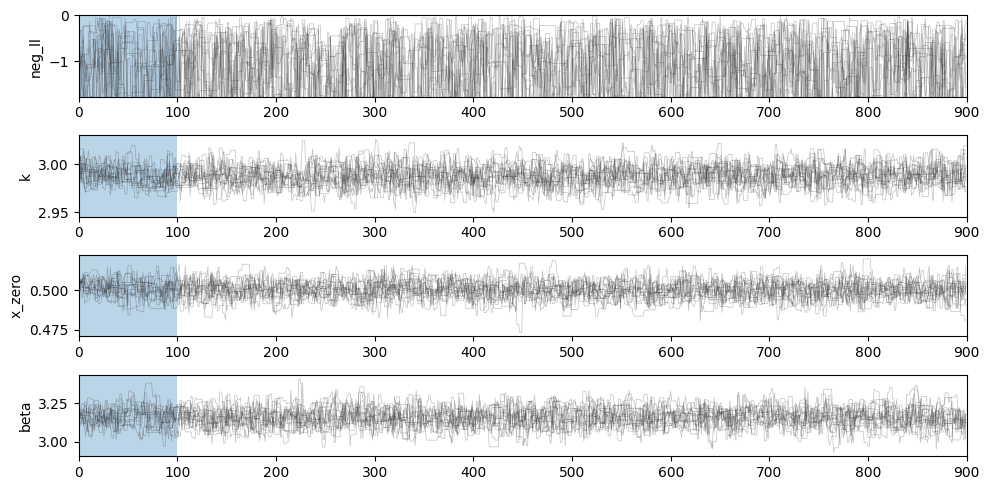

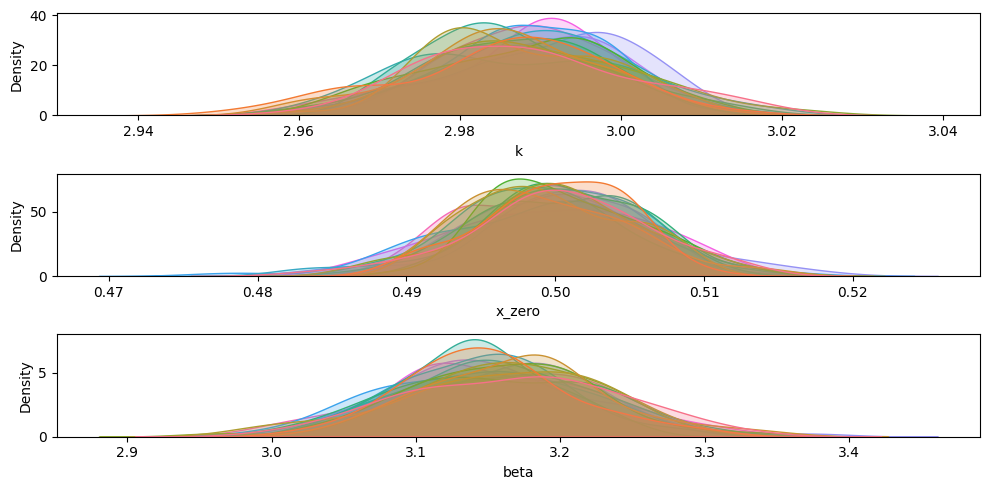

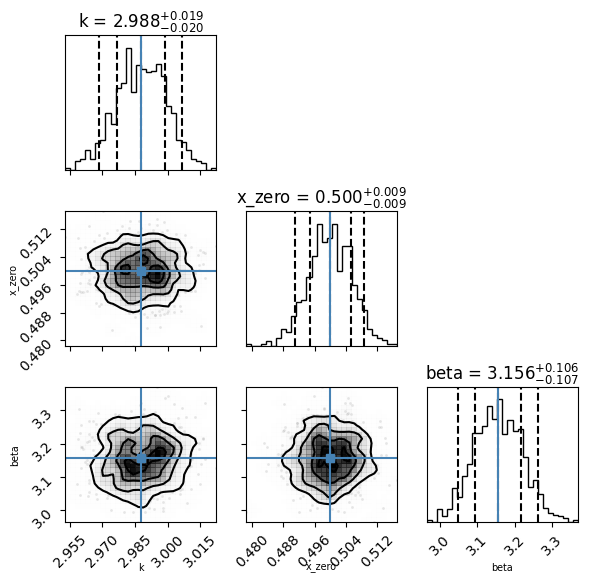

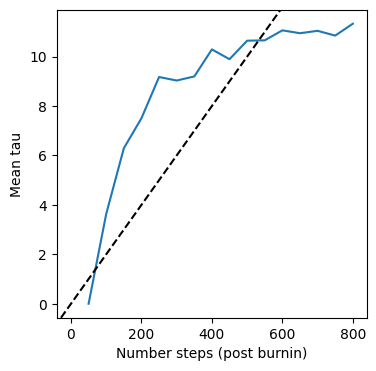

  0%|          | 0/900 [00:00<?, ?it/s]

50 steps post burnin, acceptance fraction: 0.402721088435374
100 steps post burnin, acceptance fraction: 0.3952861952861953
150 steps post burnin, acceptance fraction: 0.38255033557046975
200 steps post burnin, acceptance fraction: 0.3852596314907873
250 steps post burnin, acceptance fraction: 0.38420348058902276
300 steps post burnin, acceptance fraction: 0.3841694537346712
350 steps post burnin, acceptance fraction: 0.3851002865329513
400 steps post burnin, acceptance fraction: 0.3822890559732664
450 steps post burnin, acceptance fraction: 0.3812917594654789
500 steps post burnin, acceptance fraction: 0.3787575150300602
550 steps post burnin, acceptance fraction: 0.37729204614450507
600 steps post burnin, acceptance fraction: 0.3781858653311074
650 steps post burnin, acceptance fraction: 0.3795582948125321
700 steps post burnin, acceptance fraction: 0.3779685264663805
750 steps post burnin, acceptance fraction: 0.37730307076101466
800 steps post burnin, acceptance fraction: 0.3764705

In [20]:
# How many parallel process to use
processes = 4

# Set the seed to ensure reproducibility
np.random.seed(485765)

## MCMC options
# Unclear at the start how many iterations are needed to sample
# the posterior appropriately, normally requires looking at the
# chains and then just running them for longer if needed.
# This number is about right for our toy example.
max_iterations = 900
burnin = 100
thin = 15

## Visualisation options
plot_every = 50
convergence_ratio = 50
parameter_order = [p[0] for p in parameters]
neg_log_likelihood_name = "neg_ll"
labels_chain = [neg_log_likelihood_name] + parameter_order

# Stores for autocorr over steps
autocorr = np.zeros(max_iterations)
autocorr_steps = np.zeros(max_iterations)
index = 0

## Setup plots
fig_chain, axd_chain = plt.subplot_mosaic(
    mosaic=[[l] for l in labels_chain],
    figsize=(10, 5),
)
holder_chain = display(fig_chain, display_id=True)

fig_dist, axd_dist = plt.subplot_mosaic(
    mosaic=[[l] for l in parameter_order],
    figsize=(10, 5),
)
holder_dist = display(fig_dist, display_id=True)

fig_corner = plt.figure(figsize=(6, 6))
holder_corner = display(fig_dist, display_id=True)

fig_tau, ax_tau = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(4, 4),
)
holder_tau = display(fig_tau, display_id=True)

# Plottting helper
truths_corner = [truth[k].to(u).m for k, u in parameters]

with Pool(processes=processes) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_prob,
        moves=move,
        backend=backend,
        blobs_dtype=[("neg_log_prior", float), ("neg_log_likelihood", float)],
        pool=pool,
    )

    for sample in sampler.sample(
        # If statement in case we're continuing a run rather than starting fresh
        start_emcee if sampler.iteration < 1 else sampler.get_last_sample(),
        iterations=max_iterations,
        progress="notebook",
        progress_kwargs={"leave": True},
    ):
        if sampler.iteration % plot_every or sampler.iteration < 2:
            continue

        if sampler.iteration < burnin + 1:
            in_burn_in = True
        else:
            in_burn_in = False

        for ax in axd_chain.values():
            ax.clear()

        emcee_plotting.plot_chains(
            inp=sampler,
            burnin=burnin,
            parameter_order=parameter_order,
            axes_d=axd_chain,
            neg_log_likelihood_name=neg_log_likelihood_name,
        )
        fig_chain.tight_layout()
        holder_chain.update(fig_chain)

        if not in_burn_in:
            chain_post_burnin = sampler.get_chain(discard=burnin)
            if chain_post_burnin.shape[0] > 0:
                acceptance_fraction = np.mean(
                    get_acceptance_fractions(chain_post_burnin)
                )
                print(
                    f"{chain_post_burnin.shape[0]} steps post burnin, "
                    f"acceptance fraction: {acceptance_fraction}"
                )

            for ax in axd_dist.values():
                ax.clear()

            emcee_plotting.plot_dist(
                inp=sampler,
                burnin=burnin,
                thin=thin,
                parameter_order=parameter_order,
                axes_d=axd_dist,
                warn_singular=False,
            )
            fig_dist.tight_layout()
            holder_dist.update(fig_dist)

            try:
                fig_corner.clear()
                emcee_plotting.plot_corner(
                    inp=sampler,
                    burnin=burnin,
                    thin=thin,
                    parameter_order=parameter_order,
                    fig=fig_corner,
                    truths=truths_corner,
                )
                fig_corner.tight_layout()
                holder_corner.update(fig_corner)
            except AssertionError:
                pass

            autocorr_bits = get_autocorrelation_info(
                sampler,
                burnin=burnin,
                thin=thin,
                autocorr_tol=0,
                convergence_ratio=convergence_ratio,
            )
            autocorr[index] = autocorr_bits["autocorr"]
            autocorr_steps[index] = sampler.iteration - burnin
            index += 1

            if np.sum(autocorr > 0) > 1 and np.sum(~np.isnan(autocorr)) > 1:
                # plot autocorrelation, pretty specific to setup so haven't
                # created separate function
                ax_tau.clear()
                ax_tau.plot(
                    autocorr_steps[:index],
                    autocorr[:index],
                )
                ax_tau.axline(
                    (0, 0), slope=1 / convergence_ratio, color="k", linestyle="--"
                )
                ax_tau.set_ylabel("Mean tau")
                ax_tau.set_xlabel("Number steps (post burnin)")
                holder_tau.update(fig_tau)

# Close all the figures
for _ in range(4):
    plt.close()

In this case, our MCMC converges nicely (although convergence is of course not an exact science).

## Plotting a live run

If we run an MCMC chain with an HDF5 backend, we can plot it after the chain has finished or even while the chain is running (this can fail if the HDF5 read is at just the wrong time, but this is very rare in our experience and is solved by https://github.com/dfm/emcee/pull/395 (check if this has been merged and update appropriately)). The cells below how to make such plots. You could also run them in a standalone notebook.

Number thinned samples per chain: 66
Number thinned samples: 990
autocorr_bits['autocorr'] * autocorr_bits['convergence_ratio']=542.9831625614182
autocorr_bits['steps_post_burnin']=800
Converged? True


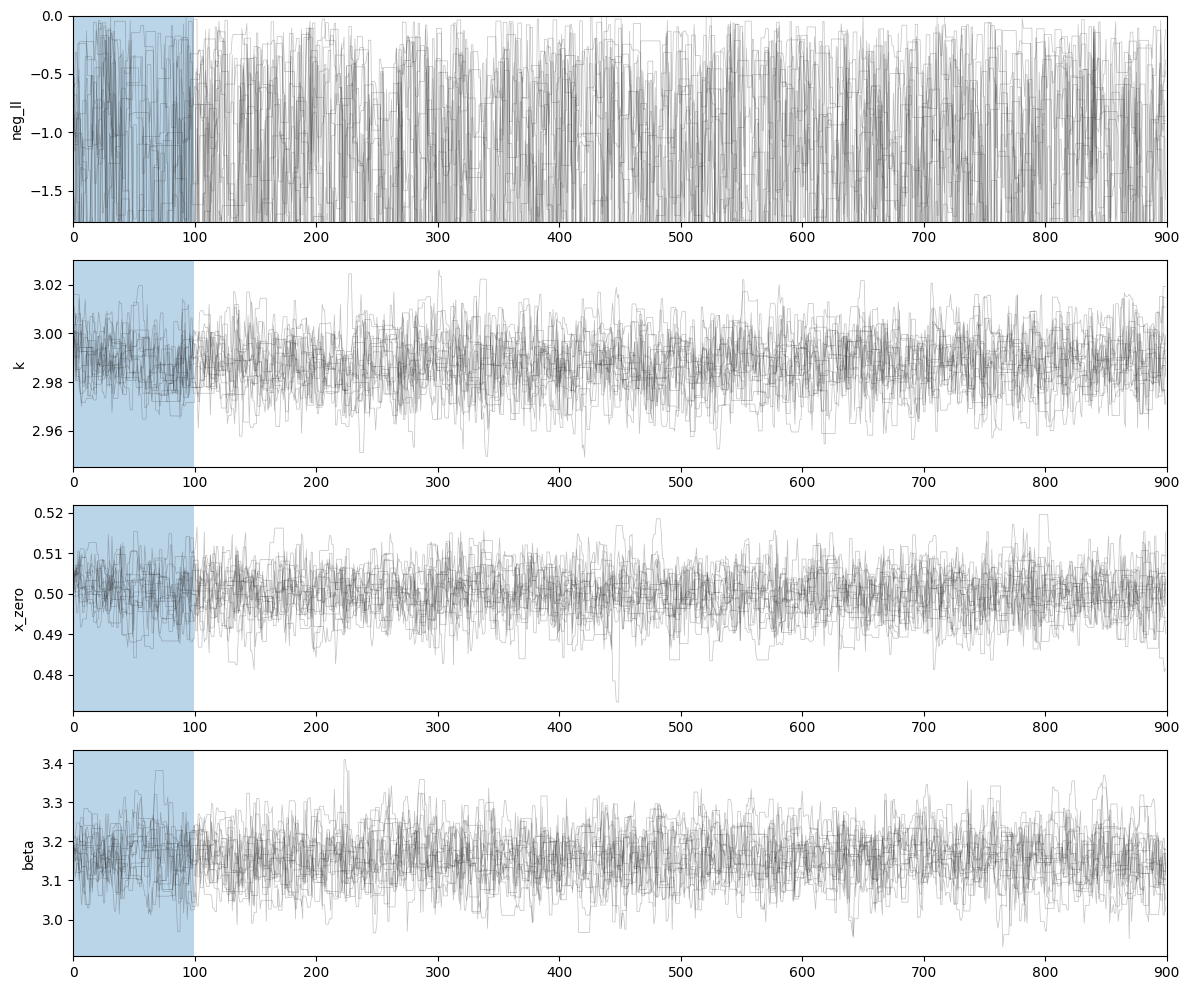

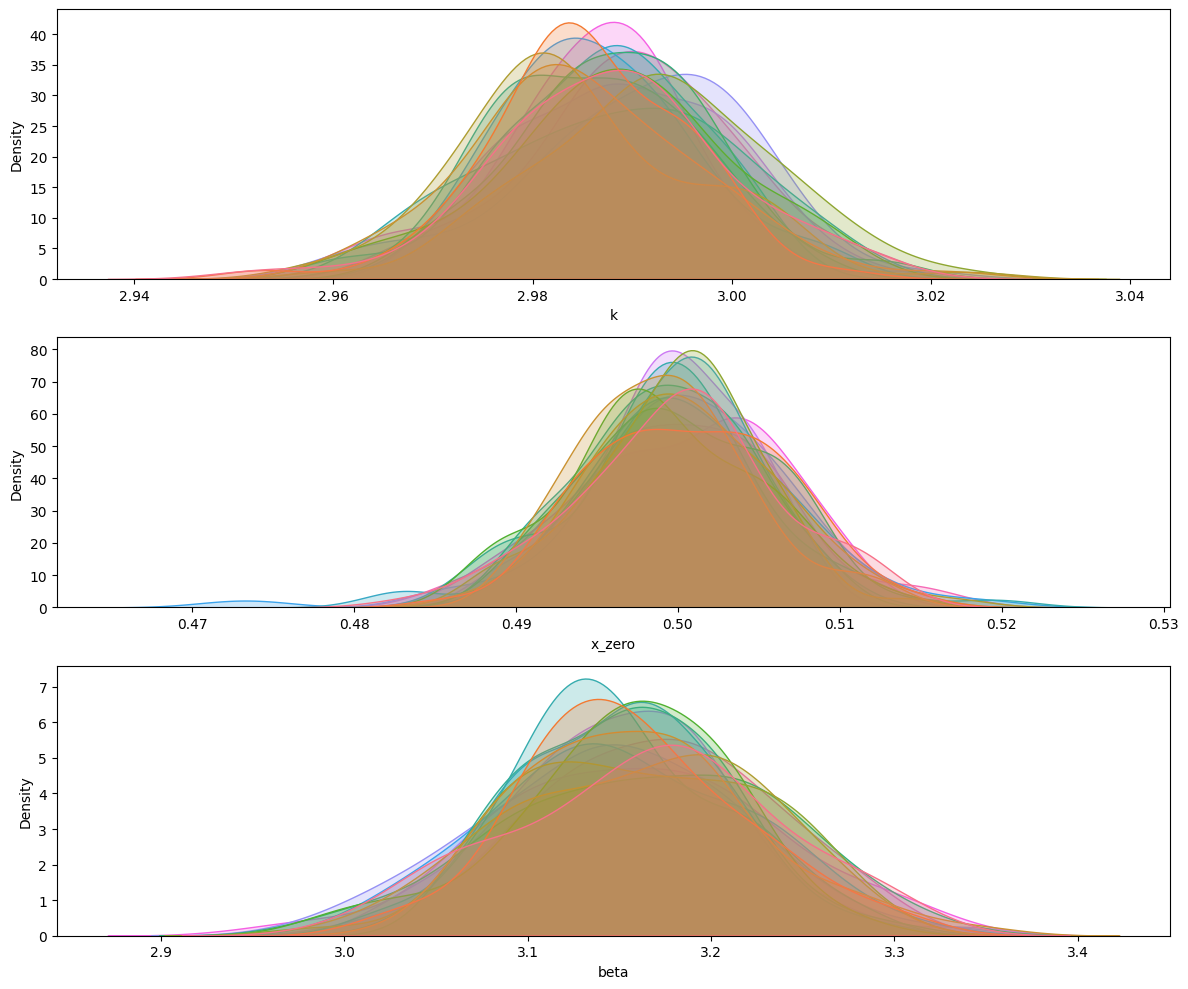

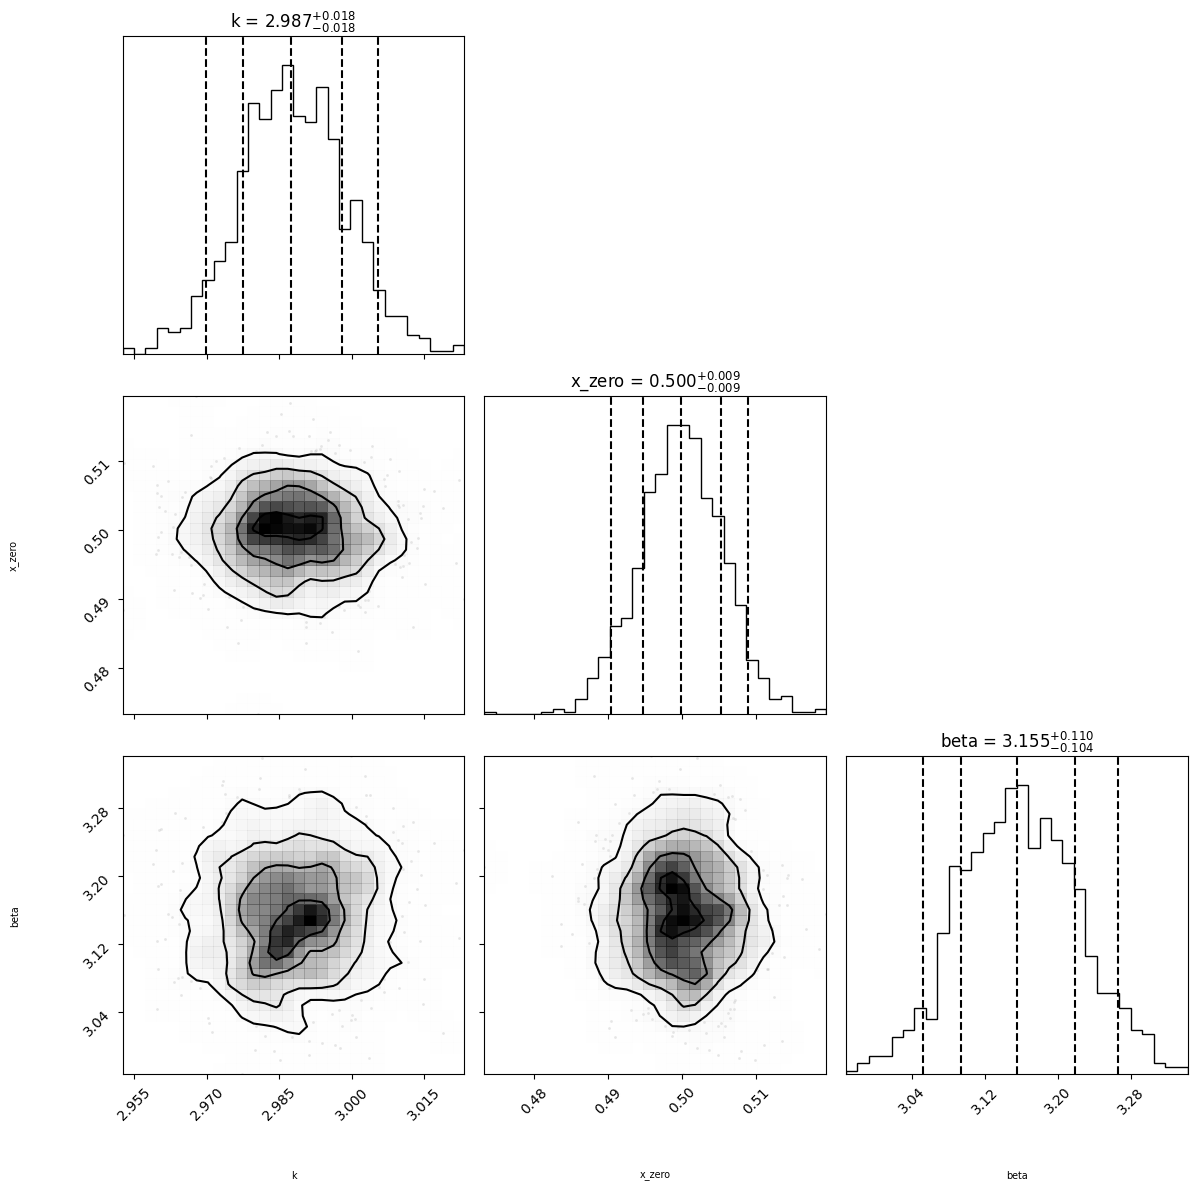

In [31]:
reader = emcee.backends.HDFBackend("basic-demo-mcmc.h5")

burnin = 100
thin = 12

# You do have to know the parameter order used by your
# backend. Creating a new backend which stored this too
# would be a nice PR into openscm-calibration.
parameter_order = [
    ("k"),
    ("x_zero"),
    ("beta"),
]
neg_log_likelihood_name = "neg_ll"
labels_chain = [neg_log_likelihood_name] + parameter_order

fig_chain, axd_chain = plt.subplot_mosaic(
    mosaic=[[l] for l in labels_chain],
    figsize=(12, 10),
)

fig_dist, axd_dist = plt.subplot_mosaic(
    mosaic=[[l] for l in parameter_order],
    figsize=(12, 10),
)

fig_corner = plt.figure(figsize=(12, 12))


emcee_plotting.plot_chains(
    inp=reader,
    burnin=burnin,
    parameter_order=parameter_order,
    axes_d=axd_chain,
    neg_log_likelihood_name=neg_log_likelihood_name,
)

emcee_plotting.plot_dist(
    inp=reader,
    burnin=burnin,
    thin=thin,
    parameter_order=parameter_order,
    axes_d=axd_dist,
)

emcee_plotting.plot_corner(
    inp=reader,
    burnin=burnin,
    thin=thin,
    parameter_order=parameter_order,
    fig=fig_corner,
)

fig_chain.tight_layout()
fig_dist.tight_layout()
fig_corner.tight_layout()

print(
    f"Number thinned samples per chain: {reader.get_chain(discard=burnin, thin=thin, flat=False).shape[0]}"
)
print(
    f"Number thinned samples: {reader.get_chain(discard=burnin, thin=thin, flat=True).shape[0]}"
)

autocorr_bits = get_autocorrelation_info(
    reader, burnin=burnin, thin=thin, autocorr_tol=0, convergence_ratio=50
)

print(f"{autocorr_bits['autocorr'] * autocorr_bits['convergence_ratio']=}")
print(f"{autocorr_bits['steps_post_burnin']=}")
print(f"Converged? {autocorr_bits['converged']}")

## Adding degeneracy

Sometimes, our model parameters are underconstrained. For our toy example here, we can make this the case by adding the model's mass into the parameters to constrain. If we do this and run the MCMC again, we can see this degeneracy appear. Such a degeneracy would also cause issues for our optimisation, as equally good fits could be found with different parameter values. This is something to keep in mind and is a good reason to run MCMC after optimisation (i.e. the MCMC should be run as a check because it will reveal degeneracy that optimisation alone will not).

truth_incl_mass


{'k': 3000 <Unit('kilogram / second ** 2')>,
 'x_zero': 0.5 <Unit('meter')>,
 'beta': 100000000000.0 <Unit('kilogram / second')>,
 'm': 120 <Unit('petametric_ton')>}

/Users/znicholls/Documents/AGCEC/MCastle/openscm-calibration_examples/.venv/lib/python3.11/site-packages/scmdata/plotting.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


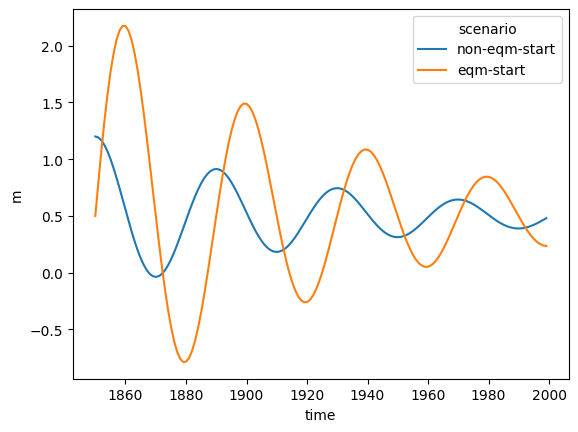

parameters


[('k', 'Pt / yr ^ 2'), ('x_zero', 'm'), ('beta', 'Pt / yr'), ('m', 'Pt')]

Model runner


OptModelRunner(convert_x_to_names_with_units=functools.partial(<function x_and_parameters_to_named_with_units at 0x1250b3600>, params=[('k', 'Pt / yr ^ 2'), ('x_zero', 'm'), ('beta', 'Pt / yr'), ('m', 'Pt')]), do_model_runs_input_generator=<function do_model_runs_input_generator_incl_mass at 0x1284e2a20>, do_model_runs=<function do_experiments_full at 0x1250da7a0>)

Example cost


5478.551430424355

Bounds dictionary


{'k': [300 <Unit('kilogram / second ** 2')>,
  10000.0 <Unit('kilogram / second ** 2')>],
 'x_zero': [-2 <Unit('meter')>, 2 <Unit('meter')>],
 'beta': [10000000000.0 <Unit('kilogram / second')>,
  1000000000000.0 <Unit('kilogram / second')>],
 'm': [10 <Unit('petametric_ton')>, 1000 <Unit('petametric_ton')>]}

In [22]:
truth_incl_mass = {
    "k": UREG.Quantity(3000, "kg / s^2"),
    "x_zero": UREG.Quantity(0.5, "m"),
    "beta": UREG.Quantity(1e11, "kg / s"),
    "m": UREG.Quantity(120, "Pt"),
}
print("truth_incl_mass")
display(truth_incl_mass)

target_incl_mass = do_experiments_full(**truth_incl_mass)
target_incl_mass["model"] = "target"
target_incl_mass.lineplot(time_axis="year-month")
plt.show()

parameters_incl_mass = [
    ("k", f"{MASS_UNITS} / {TIME_UNITS} ^ 2"),
    ("x_zero", LENGTH_UNITS),
    ("beta", f"{MASS_UNITS} / {TIME_UNITS}"),
    ("m", MASS_UNITS),
]
print("parameters")
display(parameters_incl_mass)
parameter_order_incl_mass = [v[0] for v in parameters_incl_mass]

def do_model_runs_input_generator_incl_mass(
    k: pint.Quantity, x_zero: pint.Quantity, beta: pint.Quantity, m: pint.Quantity
) -> Dict[str, pint.Quantity]:
    """
    Create the inputs for :func:`do_experiments`

    Parameters
    ----------
    k
        k

    x_zero
        x_zero

    beta
        beta
        
    m 
        Mass

    Returns
    -------
        Inputs for :func:`do_experiments`
    """
    return {"k": k, "x_zero": x_zero, "beta": beta, "m": m}


model_runner_incl_mass = OptModelRunner.from_parameters(
    params=parameters_incl_mass,
    do_model_runs_input_generator=do_model_runs_input_generator_incl_mass,
    do_model_runs=do_experiments_full,
)
print("Model runner")
display(model_runner_incl_mass)

print("Example cost")
display(cost_calculator.calculate_cost(model_runner_incl_mass.run_model([3, 0.5, 3, 10])))

bounds_dict_incl_mass = {
    "k": [
        UREG.Quantity(300, "kg / s^2"),
        UREG.Quantity(1e4, "kg / s^2"),
    ],
    "x_zero": [
        UREG.Quantity(-2, "m"),
        UREG.Quantity(2, "m"),
    ],
    "beta": [
        UREG.Quantity(1e10, "kg / s"),
        UREG.Quantity(1e12, "kg / s"),
    ],
    "m": [
        UREG.Quantity(10, "Pt"),
        UREG.Quantity(1000, "Pt"),
    ]
}
print("Bounds dictionary")
display(bounds_dict_incl_mass)

bounds_incl_mass = [[v.to(unit).m for v in bounds_dict_incl_mass[k]] for k, unit in parameters_incl_mass]
neg_log_prior_incl_mass = partial(neg_log_prior_bounds, bounds=np.array(bounds_incl_mass))

log_prob_incl_mass = partial(
    log_prob_full, 
    neg_log_prior=neg_log_prior_incl_mass, 
    model_runner=model_runner_incl_mass, 
    cost_calculator=cost_calculator,
)


ndim_incl_mass = len(bounds_incl_mass)
nwalkers_incl_mass = 5 * ndim_incl_mass

start_emcee_incl_mass = [4, 1.2, 20, 100]
start_emcee_incl_mass = [s + s / 10 * np.random.rand(nwalkers_incl_mass) for s in start_emcee_incl_mass]
start_emcee_incl_mass = np.vstack(start_emcee_incl_mass).T

move_incl_mass = DIMEMove()

# Use HDF5 backend, this saves things to disk and lets
# you check plotting halfway through (for example)
filename_incl_mass = "basic-demo-mcmc_incl-mass.h5"
backend_incl_mass = emcee.backends.HDFBackend(filename_incl_mass)
backend_incl_mass.reset(nwalkers_incl_mass, ndim_incl_mass)

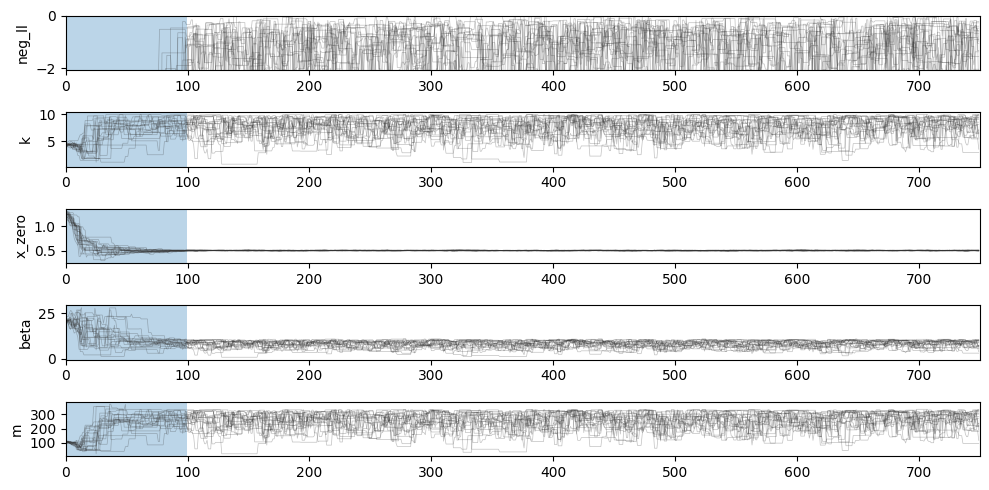

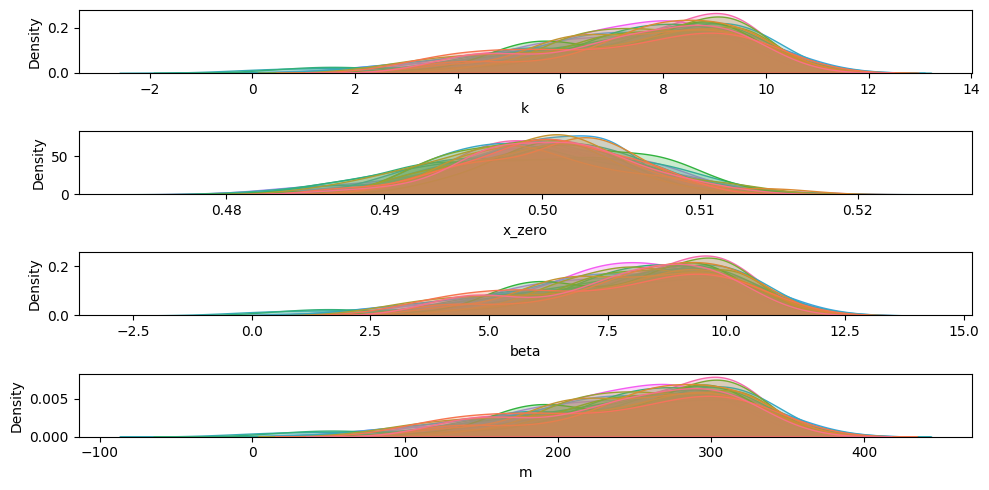

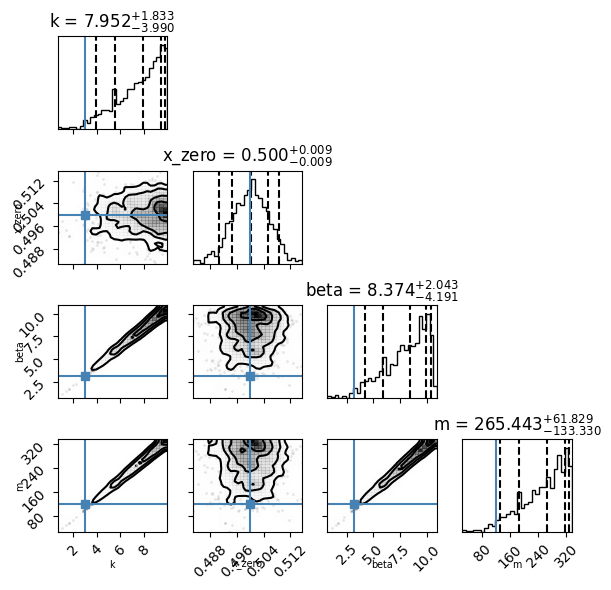

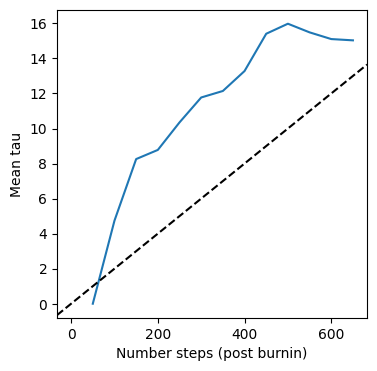

  0%|          | 0/750 [00:00<?, ?it/s]

/Users/znicholls/Documents/AGCEC/MCastle/openscm-calibration_examples/.venv/lib/python3.11/site-packages/emcwrap/moves.py:91: RuntimeWarning: divide by zero encountered in log
  np.log(sum(self.accepted)) - np.log(nchain)


50 steps post burnin, acceptance fraction: 0.2510204081632653
100 steps post burnin, acceptance fraction: 0.27676767676767683
150 steps post burnin, acceptance fraction: 0.27449664429530196
200 steps post burnin, acceptance fraction: 0.27839195979899495


/Users/znicholls/Documents/AGCEC/MCastle/openscm-calibration_examples/.venv/lib/python3.11/site-packages/emcwrap/moves.py:91: RuntimeWarning: divide by zero encountered in log
  np.log(sum(self.accepted)) - np.log(nchain)


250 steps post burnin, acceptance fraction: 0.27429718875502007
300 steps post burnin, acceptance fraction: 0.2760869565217391
350 steps post burnin, acceptance fraction: 0.27922636103151854
400 steps post burnin, acceptance fraction: 0.2818295739348371
450 steps post burnin, acceptance fraction: 0.2826280623608018
500 steps post burnin, acceptance fraction: 0.2816633266533066
550 steps post burnin, acceptance fraction: 0.27969034608378873
600 steps post burnin, acceptance fraction: 0.28080133555926545


/Users/znicholls/Documents/AGCEC/MCastle/openscm-calibration_examples/.venv/lib/python3.11/site-packages/emcwrap/moves.py:91: RuntimeWarning: divide by zero encountered in log
  np.log(sum(self.accepted)) - np.log(nchain)


650 steps post burnin, acceptance fraction: 0.28135593220338984


In [23]:
processes = 4

max_iterations = 750
burnin = 100
thin = 15

## Visualisation options
plot_every = 50
convergence_ratio = 50
labels_chain_incl_mass = [neg_log_likelihood_name] + parameter_order_incl_mass

# Stores for autocorr over steps
autocorr = np.zeros(max_iterations)
autocorr_steps = np.zeros(max_iterations)
index = 0

## Setup plots
fig_chain_incl_mass, axd_chain_incl_mass = plt.subplot_mosaic(
    mosaic=[[l] for l in labels_chain_incl_mass],
    figsize=(10, 5),
)
holder_chain_incl_mass = display(fig_chain_incl_mass, display_id=True)

fig_dist_incl_mass, axd_dist_incl_mass = plt.subplot_mosaic(
    mosaic=[[l] for l in parameter_order_incl_mass],
    figsize=(10, 5),
)
holder_dist_incl_mass = display(fig_dist_incl_mass, display_id=True)

fig_corner_incl_mass = plt.figure(figsize=(6, 6))
holder_corner_incl_mass = display(fig_dist_incl_mass, display_id=True)

fig_tau_incl_mass, ax_tau_incl_mass = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(4, 4),
)
holder_tau_incl_mass = display(fig_tau_incl_mass, display_id=True)

truths_corner_incl_mass = [truth_incl_mass[k].to(u).m for k, u in parameters_incl_mass]

with Pool(processes=processes) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers_incl_mass,
        ndim_incl_mass,
        log_prob_incl_mass,
        moves=move_incl_mass,
        backend=backend_incl_mass,
        blobs_dtype=[("neg_log_prior", float), ("neg_log_likelihood", float)],
        pool=pool,
    )

    for sample in sampler.sample(
        start_emcee_incl_mass if sampler.iteration < 1 else sampler.get_last_sample(),
        iterations=max_iterations,
        progress="notebook",
        progress_kwargs={"leave": True},
    ):
        if sampler.iteration % plot_every or sampler.iteration < 2:
            continue

        if sampler.iteration < burnin + 1:
            in_burn_in = True
        else:
            in_burn_in = False

        for ax in axd_chain_incl_mass.values():
            ax.clear()

        emcee_plotting.plot_chains(
            inp=sampler,
            burnin=burnin,
            parameter_order=parameter_order_incl_mass,
            axes_d=axd_chain_incl_mass,
            neg_log_likelihood_name=neg_log_likelihood_name,
        )
        fig_chain_incl_mass.tight_layout()
        holder_chain_incl_mass.update(fig_chain_incl_mass)

        if not in_burn_in:
            chain_post_burnin = sampler.get_chain(discard=burnin)
            if chain_post_burnin.shape[0] > 0:
                acceptance_fraction = np.mean(
                    get_acceptance_fractions(chain_post_burnin)
                )
                print(
                    f"{chain_post_burnin.shape[0]} steps post burnin, "
                    f"acceptance fraction: {acceptance_fraction}"
                )

            for ax in axd_dist_incl_mass.values():
                ax.clear()

            emcee_plotting.plot_dist(
                inp=sampler,
                burnin=burnin,
                thin=thin,
                parameter_order=parameter_order_incl_mass,
                axes_d=axd_dist_incl_mass,
                warn_singular=False,
            )
            fig_dist_incl_mass.tight_layout()
            holder_dist_incl_mass.update(fig_dist_incl_mass)

            try:
                fig_corner_incl_mass.clear()
                emcee_plotting.plot_corner(
                    inp=sampler,
                    burnin=burnin,
                    thin=thin,
                    parameter_order=parameter_order_incl_mass,
                    fig=fig_corner_incl_mass,
                    truths=truths_corner_incl_mass,
                )
                fig_corner_incl_mass.tight_layout()
                holder_corner_incl_mass.update(fig_corner_incl_mass)
            except AssertionError:
                pass

            autocorr_bits = get_autocorrelation_info(
                sampler,
                burnin=burnin,
                thin=thin,
                autocorr_tol=0,
                convergence_ratio=convergence_ratio,
            )
            autocorr[index] = autocorr_bits["autocorr"]
            autocorr_steps[index] = sampler.iteration - burnin
            index += 1

            if np.sum(autocorr > 0) > 1 and np.sum(~np.isnan(autocorr)) > 1:
                ax_tau_incl_mass.clear()
                ax_tau_incl_mass.plot(
                    autocorr_steps[:index],
                    autocorr[:index],
                )
                ax_tau_incl_mass.axline(
                    (0, 0), slope=1 / convergence_ratio, color="k", linestyle="--"
                )
                ax_tau_incl_mass.set_ylabel("Mean tau")
                ax_tau_incl_mass.set_xlabel("Number steps (post burnin)")
                holder_tau_incl_mass.update(fig_tau_incl_mass)

# Close all the figures
for _ in range(4):
    plt.close()

Thanks to the MCMC chain, the degeneracy between $m$, $k$ and $\beta$ is obvious. We don't get much information about the parameter values from the calibration because of the degeneracy, and this shows up in the probability distributions which don't have clear peaks (the uncertainty on the parameter values except $x_0$ is very large). In this case they are hitting up against the bounds but they really could end up anywhere because the true probability distributions are very flat. In such cases, we have to be careful about how we interpret such plots. As we can see, the truth is inside the distribution, but it isn't where the mode of the distribution is. If you're parameters look like they're hitting your bounds, it is a good sign that something isn't going as planned.